In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


import keras_tuner as kt
from GraphTransformerPrerocess import graph_global_transformer_local_process
from graph import graph_topology_5
from models.graph_global_transformer_local import graph_global_transformer_local

2023-07-22 21:44:22.016626: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 21:44:23.619462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

### Parameters

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5


# ===== model parameters ======
embed_feat = 4
head_size = 48*2
num_heads = 3
ff_dim = 48
num_transformer_blocks = 1
dropout = 0.5
atte_reg = 1e-2
l1_reg = 0
l2_reg = 1e-4
gcn_unit1 = 48
gcn_unit2 = 32
gcn_unit3 = 16
lstm_units = 32
learning_rate = 1e-3
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

### Preprocess

In [4]:
train_26, val_26, test_26, \
train_25B, val_25B, test_25B, \
train_25A, val_25A, test_25A, \
train_1, val_1, test_1, \
train_4, val_4, test_4, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = graph_global_transformer_local_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
print(train_26.shape, val_26.shape, test_26.shape, 
      train_25B.shape, val_25B.shape, test_25B.shape, 
      train_25A.shape, val_25A.shape, test_25A.shape, 
      train_1.shape, val_1.shape, test_1.shape, 
      train_4.shape, val_4.shape, test_4.shape, 
      train_ws_y.shape, val_ws_y.shape, test_ws_y.shape
     )

(77069, 96, 6) (9634, 96, 6) (19268, 96, 6) (77069, 96, 6) (9634, 96, 6) (19268, 96, 6) (77069, 96, 4) (9634, 96, 4) (19268, 96, 4) (77069, 96, 2) (9634, 96, 2) (19268, 96, 2) (77069, 96, 2) (9634, 96, 2) (19268, 96, 2) (77069, 96) (9634, 96) (19268, 96)


### Graph topology

In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Model

In [7]:
S26_shape = (train_26.shape[1], train_26.shape[2])
S25B_shape = (train_25B.shape[1], train_25B.shape[2])
S25A_shape = (train_25A.shape[1], train_25A.shape[2])
S1_shape = (train_1.shape[1], train_1.shape[2])
S4_shape = (train_4.shape[1], train_4.shape[2])

In [8]:
model, GCNConv = graph_global_transformer_local(gcn1=gcn_unit1,
                                                gcn2=gcn_unit2,
                                                gcn3=gcn_unit3,
                                                lstm_unit=lstm_units, 
                                                num_transformer_blocks=num_transformer_blocks,
                                                head_size=head_size,
                                                num_heads=num_heads,
                                                ff_dim=ff_dim, 
                                                atte_reg=atte_reg, 
                                                l1_reg=l1_reg, 
                                                l2_reg=l2_reg, 
                                                dropout=dropout,
                                                masked_value=masked_value,
                                                embed_feat=embed_feat,
                                                S26_shape=S26_shape, 
                                                S25B_shape=S25B_shape, 
                                                S25A_shape=S25A_shape, 
                                                S1_shape=S1_shape,
                                                S4_shape=S4_shape
                                               )
model.summary()

2023-07-22 21:44:34.876550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 6)]              0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 96, 6)]              0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 96, 4)]              0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 96, 2)]              0         []                            
                                                                                              

 dropout_1 (Dropout)         (None, 96, 48)               0         ['dense[0][0]']               
                                                                                                  
 dropout_3 (Dropout)         (None, 96, 48)               0         ['dense_2[0][0]']             
                                                                                                  
 dropout_5 (Dropout)         (None, 96, 48)               0         ['dense_4[0][0]']             
                                                                                                  
 dropout_7 (Dropout)         (None, 96, 48)               0         ['dense_6[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 96, 48)               0         ['dense_8[0][0]']             
                                                                                                  
 dense_1 (

 GCNConv2 (GCNConv)          (None, 5, 32)                1568      ['GCNConv1[0][0]',            
                                                                     'input_lap[0][0]']           
                                                                                                  
 LSTM (LSTM)                 (None, 5, 32)                53376     ['reshape_global[0][0]']      
                                                                                                  
 concat_global (Concatenate  (None, 5, 64)                0         ['GCNConv2[0][0]',            
 )                                                                   'LSTM[0][0]']                
                                                                                                  
 dense_10 (Dense)            (None, 5, 32)                2080      ['concat_global[0][0]']       
                                                                                                  
 attention

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('saved_models/graph_global_transformer_local_gate_pump_1.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     custom_objects={'GCNConv': GCNConv},
                     save_best_only=True
                    )


model.fit([train_26, train_25B, train_25A, train_1, train_4, train_adj_mat], train_ws_y,
           validation_data=([test_26, test_25B, test_25A, test_1, test_4, test_adj_mat], test_ws_y),
           epochs=EPOCHS,
           batch_size=BATCH,
           verbose=2,
           shuffle=True,
           callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-22 21:44:51.189230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-22 21:44:52.292636: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcc3c00b8e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-22 21:44:52.292699: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-22 21:44:52.303315: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-22 21:44:52.751096: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.31143, saving model to saved_models/graph_global_transformer_local_gate_pump_1.h5


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 - 54s - loss: 0.6033 - mae: 0.1693 - val_loss: 0.2851 - val_mae: 0.3114 - 54s/epoch - 358ms/step
Epoch 2/3000

Epoch 2: val_mae improved from 0.31143 to 0.20491, saving model to saved_models/graph_global_transformer_local_gate_pump_1.h5
151/151 - 22s - loss: 0.1010 - mae: 0.0923 - val_loss: 0.1005 - val_mae: 0.2049 - 22s/epoch - 147ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.20491 to 0.11123, saving model to saved_models/graph_global_transformer_local_gate_pump_1.h5
151/151 - 22s - loss: 0.0371 - mae: 0.0574 - val_loss: 0.0393 - val_mae: 0.1112 - 22s/epoch - 147ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.11123 to 0.06268, saving model to saved_models/graph_global_transformer_local_gate_pump_1.h5
151/151 - 22s - loss: 0.0204 - mae: 0.0409 - val_loss: 0.0210 - val_mae: 0.0627 - 22s/epoch - 147ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.06268 to 0.04821, saving model to saved_models/graph_global_transformer_local_gate_pump_1.h5
151/151 - 22s - loss

Epoch 38/3000

Epoch 38: val_mae improved from 0.03008 to 0.02995, saving model to saved_models/graph_global_transformer_local_gate_pump_1.h5
151/151 - 22s - loss: 0.0020 - mae: 0.0138 - val_loss: 0.0029 - val_mae: 0.0300 - 22s/epoch - 143ms/step
Epoch 39/3000

Epoch 39: val_mae did not improve from 0.02995
151/151 - 21s - loss: 0.0018 - mae: 0.0135 - val_loss: 0.0028 - val_mae: 0.0302 - 21s/epoch - 141ms/step
Epoch 40/3000

Epoch 40: val_mae improved from 0.02995 to 0.02946, saving model to saved_models/graph_global_transformer_local_gate_pump_1.h5
151/151 - 22s - loss: 0.0017 - mae: 0.0134 - val_loss: 0.0026 - val_mae: 0.0295 - 22s/epoch - 143ms/step
Epoch 41/3000

Epoch 41: val_mae did not improve from 0.02946
151/151 - 21s - loss: 0.0016 - mae: 0.0134 - val_loss: 0.0025 - val_mae: 0.0298 - 21s/epoch - 142ms/step
Epoch 42/3000

Epoch 42: val_mae did not improve from 0.02946
151/151 - 21s - loss: 0.0015 - mae: 0.0133 - val_loss: 0.0026 - val_mae: 0.0314 - 21s/epoch - 141ms/step
Epoch

Epoch 83/3000

Epoch 83: val_mae did not improve from 0.02798
151/151 - 22s - loss: 3.9401e-04 - mae: 0.0113 - val_loss: 0.0013 - val_mae: 0.0280 - 22s/epoch - 143ms/step
Epoch 84/3000

Epoch 84: val_mae did not improve from 0.02798
151/151 - 22s - loss: 3.9061e-04 - mae: 0.0112 - val_loss: 0.0014 - val_mae: 0.0283 - 22s/epoch - 143ms/step
Epoch 85/3000

Epoch 85: val_mae did not improve from 0.02798
151/151 - 22s - loss: 3.9066e-04 - mae: 0.0113 - val_loss: 0.0014 - val_mae: 0.0284 - 22s/epoch - 143ms/step
Epoch 86/3000

Epoch 86: val_mae did not improve from 0.02798
151/151 - 22s - loss: 3.8255e-04 - mae: 0.0111 - val_loss: 0.0015 - val_mae: 0.0293 - 22s/epoch - 143ms/step
Epoch 87/3000

Epoch 87: val_mae did not improve from 0.02798
151/151 - 22s - loss: 3.8250e-04 - mae: 0.0111 - val_loss: 0.0014 - val_mae: 0.0288 - 22s/epoch - 144ms/step
Epoch 88/3000

Epoch 88: val_mae improved from 0.02798 to 0.02774, saving model to saved_models/graph_global_transformer_local_gate_pump_1.h5
151

Epoch 128/3000

Epoch 128: val_mae did not improve from 0.02694
151/151 - 22s - loss: 2.8326e-04 - mae: 0.0104 - val_loss: 0.0012 - val_mae: 0.0273 - 22s/epoch - 143ms/step
Epoch 129/3000

Epoch 129: val_mae did not improve from 0.02694
151/151 - 22s - loss: 2.7915e-04 - mae: 0.0102 - val_loss: 0.0014 - val_mae: 0.0287 - 22s/epoch - 143ms/step
Epoch 130/3000

Epoch 130: val_mae did not improve from 0.02694
151/151 - 21s - loss: 2.8086e-04 - mae: 0.0103 - val_loss: 0.0013 - val_mae: 0.0278 - 21s/epoch - 142ms/step
Epoch 131/3000

Epoch 131: val_mae did not improve from 0.02694
151/151 - 21s - loss: 2.7520e-04 - mae: 0.0102 - val_loss: 0.0013 - val_mae: 0.0287 - 21s/epoch - 142ms/step
Epoch 132/3000

Epoch 132: val_mae did not improve from 0.02694
151/151 - 21s - loss: 2.7542e-04 - mae: 0.0102 - val_loss: 0.0013 - val_mae: 0.0286 - 21s/epoch - 142ms/step
Epoch 133/3000

Epoch 133: val_mae did not improve from 0.02694
151/151 - 21s - loss: 2.7221e-04 - mae: 0.0101 - val_loss: 0.0013 - val

Epoch 175/3000

Epoch 175: val_mae did not improve from 0.02664
151/151 - 22s - loss: 2.3524e-04 - mae: 0.0094 - val_loss: 0.0012 - val_mae: 0.0278 - 22s/epoch - 142ms/step
Epoch 176/3000

Epoch 176: val_mae did not improve from 0.02664
151/151 - 21s - loss: 2.3517e-04 - mae: 0.0095 - val_loss: 0.0013 - val_mae: 0.0276 - 21s/epoch - 142ms/step
Epoch 177/3000

Epoch 177: val_mae did not improve from 0.02664
151/151 - 22s - loss: 2.3459e-04 - mae: 0.0094 - val_loss: 0.0013 - val_mae: 0.0286 - 22s/epoch - 143ms/step
Epoch 178/3000

Epoch 178: val_mae did not improve from 0.02664
151/151 - 22s - loss: 2.3463e-04 - mae: 0.0094 - val_loss: 0.0013 - val_mae: 0.0282 - 22s/epoch - 143ms/step
Epoch 179/3000

Epoch 179: val_mae did not improve from 0.02664
151/151 - 22s - loss: 2.3884e-04 - mae: 0.0096 - val_loss: 0.0013 - val_mae: 0.0279 - 22s/epoch - 144ms/step
Epoch 180/3000

Epoch 180: val_mae did not improve from 0.02664
151/151 - 22s - loss: 2.3327e-04 - mae: 0.0094 - val_loss: 0.0013 - val

### Performance

In [14]:
import time

In [15]:
saved_model = load_model('saved_models/graph_global_transformer_local_gate_pump_1.h5', custom_objects={'GCNConv': GCNConv})


start_time = time.time()


yhat = saved_model.predict([test_26, test_25B, test_25A, test_1, test_4, test_adj_mat])

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))


end_time = time.time()

print("--- %s seconds ---" % (end_time - start_time))

603/603 [==============================] - 5s 7ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0738
RMSE = 0.1001
--- 5.85234808921814 seconds ---


In [ ]:
inv_yhat = pd.DataFrame(inv_yhat)
inv_yhat.to_csv('saved_results/gtn_s_inv_yhat.csv')

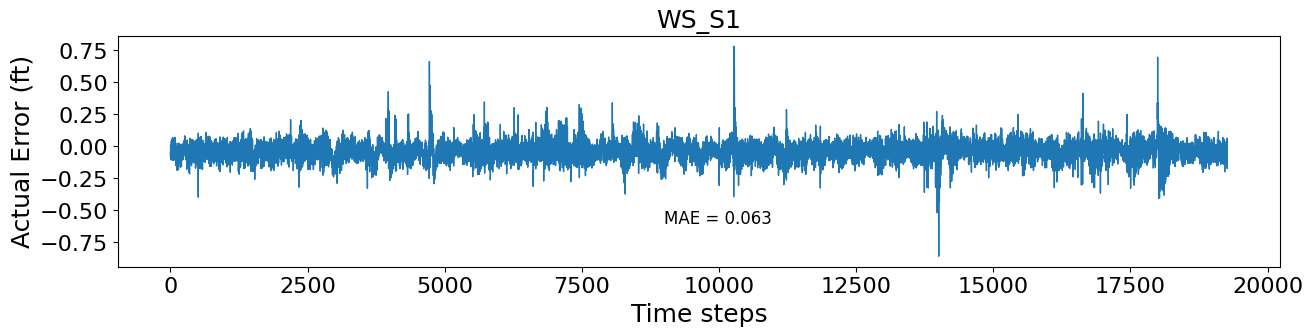

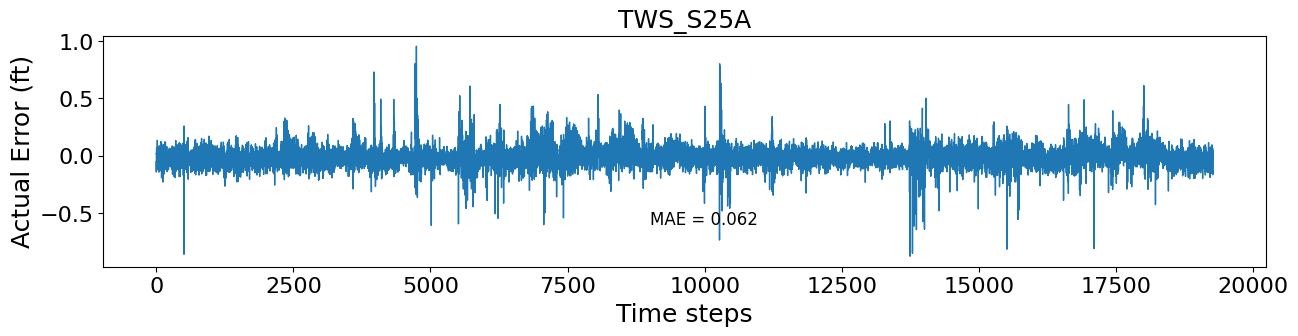

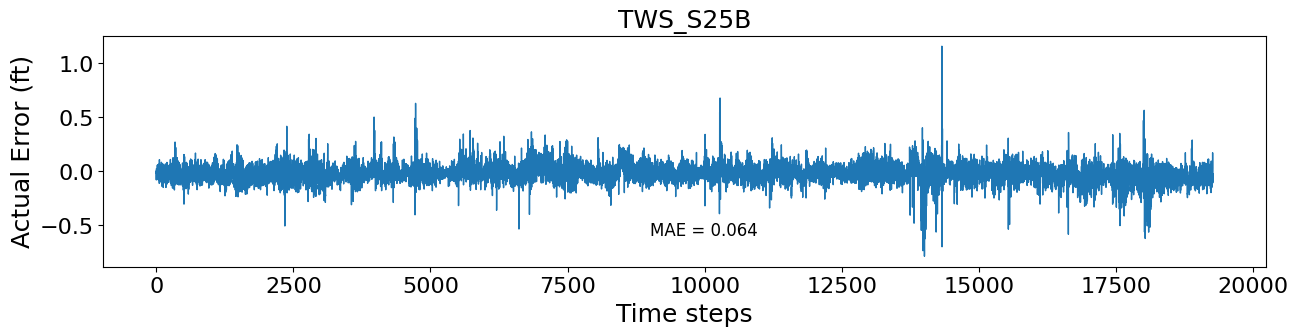

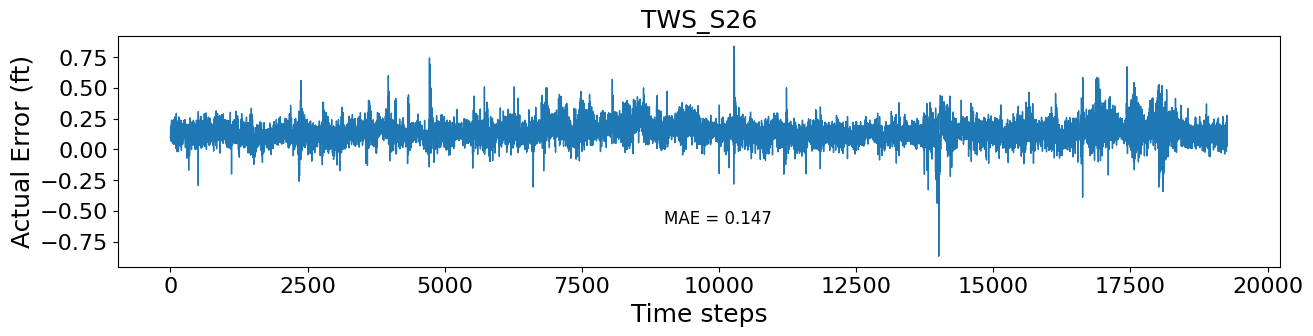

In [16]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [17]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
12
(19268,)
47
(19268,)
44
(19268,)
42


In [18]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
8
(19268,)
27
(19268,)
11
(19268,)
40


In [19]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
4
(19268,)
20
(19268,)
33
(19268,)
2


### Fine-tuning

In [10]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, atte_reg, l1_reg, l2_reg, dropout=0):
    # Normalization and Attention
    x = layers.MultiHeadAttention(key_dim=head_size, 
                                  num_heads=num_heads, 
                                  dropout=dropout, 
                                  kernel_regularizer=l2(atte_reg)
                                 )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    x1 = layers.LayerNormalization(epsilon=1e-6)(res)
#     res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, 
                      kernel_size=2, 
                      activation="relu",
                      padding='same', 
                      kernel_regularizer=keras.regularizers.L1L2(l1=l1_reg, l2=l2_reg)
                     )(x1)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], 
                      kernel_size=2,
                      activation="relu",
                      padding='same', 
                      kernel_regularizer=keras.regularizers.L1L2(l1=l1_reg, l2=l2_reg)
                     )(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    return x + res



def model_builder(hp):
    #hp_embed_feat = hp.Int('embed_feat', min_value=2, max_value=5, step=1)
    hp_ff_dim = hp.Int('ff_dim', min_value=48, max_value=128, step=16)
    hp_num_heads = hp.Choice('num_heads', values=[1, 2, 3, 4, 5, 6])
    hp_atte_reg = hp.Choice('attention_regular', values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    hp_l1_reg = hp.Choice('l1_regular', values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    hp_l2_reg = hp.Choice('l2_regular', values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    hp_lr = hp.Choice('learning_rate', values=[5e-3, 1e-3, 5e-4, 1e-4, 5e-5])
    hp_dropout = hp.Choice('dropout', values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
    hp_decay_steps = hp.Choice('decay_steps', values=[5000, 8000, 10000, 30000, 50000, 80000, 100000])
    hp_decay_rate = hp.Choice('decay_rate', values=[0.6, 0.7, 0.8, 0.9, 0.95])
    hp_gcn1_units = hp.Int('gcn1_units', min_value=16, max_value=64, step=16)
    hp_gcn2_units = hp.Int('gcn2_units', min_value=16, max_value=64, step=16)
    hp_rnn_units = hp.Int('rnn_units', min_value=32, max_value=128, step=16)
    hp_num_transformer_blocks = hp.Int('num_transformer_blocks', min_value=1, max_value=3, step=1)
    
    # covariates
    cov_inputs = keras.Input(shape=(96, 10), name='cov_inputs')
    cov = layers.Masking(mask_value=mask_value)(cov_inputs)
    for _ in range(hp_num_transformer_blocks):
        cov = transformer_encoder(cov, hp_ff_dim*2, hp_num_heads, hp_ff_dim, hp_atte_reg, hp_l1_reg, hp_l2_reg, hp_dropout)
    # cov = layers.MaxPooling1D(pool_size=2, padding='same', name='pooling')(cov)
    cov = Dense(5)(cov)
    cov_reshape = layers.Reshape((5, 96), name='cov_reshape')(cov)

    inp_lap = Input((5, 5), name='inp_lap')
    inp_seq = Input((5, 72), name='inp_seq')

    # GCN
    x = GCNConv(hp_gcn1_units, activation='relu')([inp_seq, inp_lap])
    x = GCNConv(hp_gcn2_units, activation='relu')([x, inp_lap])

    # RNN
    xx = LSTM(hp_rnn_units, activation='relu', return_sequences=True)(inp_seq)

    x = Concatenate(name='concate')([cov_reshape, x, xx])
    x = layers.Attention()([x, x])
    
    x = Flatten()(x)
    out = Dense(96)(x)

    model = Model([cov_inputs, inp_seq, inp_lap], out)
    # model.summary()
    
    # compile
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=hp_lr, 
                                                          decay_steps=hp_decay_steps,
                                                          decay_rate=hp_decay_rate)

    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='mse',
                  metrics=['mae']
                 )
    
    return model


tuner = kt.Hyperband(model_builder,
                     objective='val_mae',
                     max_epochs=400,
                     factor=3,
#                      overwrite=True,
#                      directory='my_dir',
                     project_name='gnn_transformer_parallel'
                    )


# stop_early = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=100)

# tuner1.search([train_cov, train_tws_reshape, train_adjacency_matrix], train_ws_y,
#               validation_data=([test_cov, test_tws_reshape, test_adjacency_matrix], test_ws_y),
#               batch_size=512,
# #              verbose=2,
#               shuffle=True,
#               callbacks=[stop_early]
#              )